# 02D. Bifurcation

### Mingyang Lu

### 12/21/2023

Consider one self-activating gene, 

$$\frac{dX}{dt} = f(X,k) = 10 + 45\frac{X^4}{X^4+200^4} - kX $$

In [9]:
def derivs_k(X, k):
    return 10 + 45 * (1- 1/(1+(X/200)**4)) - k*X

# Method 1: (direct method) find all roots

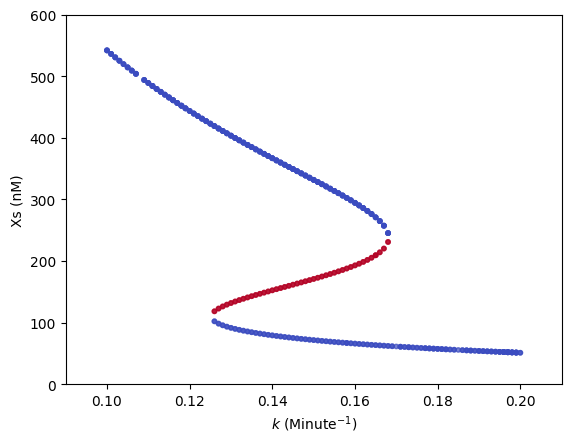

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# dx is used to estimate the derivatives of f(X) near the steady states
dx = 0.1

# All k values to be sampled (control parameter)
k_all = np.arange(0.1, 0.201, 0.001)

results = []

for k in k_all:
    # fsolve is used to find all roots by providing a vector of initial guesses
    roots = fsolve(derivs_k, x0=np.arange(50, 500, 50), args=(k,))
    # check each identified root
    for x in roots:
        # double check if the root is a steady state (abs(f) < 0.01)
        # This is added because fsolve may find wrong roots
        # uniroot.all in R seems to do a better job in finding all roots
        if abs(derivs_k(x, k)) > 0.01: 
            continue
        if 0 <= x <= 800:  # Filter out roots outside the interval [0, 800]
            if np.sign(derivs_k(X=x + dx, k=k)) < 0:  # df/dX < 0, stable
                stability = 1
            else:
                stability = 2
            results.append([k, x, stability])

results = np.array(results)

plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='coolwarm',
            marker='o', s=10, alpha=0.7)

plt.xlabel(r"$k$ (Minute$^{-1}$)")
plt.ylabel('Xs (nM)')
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.show()

## Method 2: Get bifurcation curve by simulations

Start:
* Initial $k = k_1 = 0.1$.
* A random initial condition of $X = X_0$.
* Initial direction to sample $k$: increasing ($d_1 = 1$)
* $i = 1$

While $k_i < 0.2$:  (An iteration)
1. From the initial condition $X_{i-1}$, simulate $\frac{dX}{dt} = d_i f(X, k_i)$ until a stable steady state $X_i$ is reached.
2. Record $k_i$ and $X_i$.
3. If $i \ne 1$ AND $X_i$ is very different from $X_{i-1}$:

   $d_{i+1} = -d_i$ (A bifurcation point is reached, reverse direction to sample $k$).
4. $k_{i+1} = k_i + d_{i+1} \Delta k$. (Next $k$)
5. $i = i + 1$

In Step 1, when sampling along the reverse direction of $k$, $\frac{dX}{dt} = - f(X, k)$ will converge to an unstable steady state in the original ODE. 

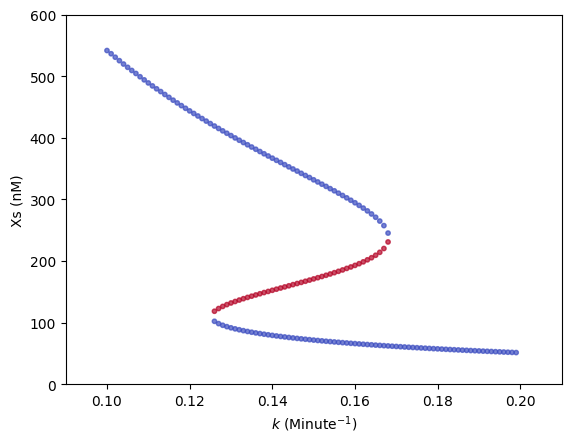

In [42]:
from scipy.integrate import solve_ivp

# Define the derivative function
def derivs_k_solve_ivp(t, X, k, d):
    # k: control parameter; d: 1 - stable steady state; 2 - unstable steady state
    return d * (10 + 45 * (1 - 1 / (1 + (X / 200)**4)) - k * X)

# Algorithm parameters
gap = 100.0      # the stop criterion for a bifurcation point
t_max = 1000.0   # Maximum ODE simulation time
dk = 0.001       # k step size 
dX = 1           # make a small step in X to estimate df/dX, a small step to perturbe X0 too

# Initialize parameters
k = 0.1
X0 = np.random.uniform(100, 600)  # Random initial condition of X
d = 1
ind = 0                 # Record the index of steady states

# Initialize results storage
results = np.full((1000, 3), np.nan)

while k < 0.2:
    # Simulate until a stable steady state is reached
    sol = solve_ivp(
        lambda t, X: derivs_k_solve_ivp(t, X, k, d),
        t_span=(0, t_max),
        y0=[X0],
        method='RK45'
    )
    Xi = sol.y.flatten()[-1]

    # Check for bifurcation point, switch the sampling direction of k.
    if ind > 0 and np.abs(Xi - X0) > gap:
        d = -d
        # Update k
        k = k + d * dk
        # Update X0, with slight perturbation along the same direction from X0 to Xi in the current step
        X0 = X0 + dX * np.sign(Xi - X0)
    else:
        # Determine stability of the steady state
        f_x_plus_dx = derivs_k_solve_ivp(0, Xi + dX, k, 1)
        stability = 1 if np.sign(f_x_plus_dx) < 0 else 2
        
        # record the steady state
        results[ind, :] = [k, Xi, stability]

        # Update k and the initial X for the next iteration
        k = k + d * dk
        X0 = Xi
        # Update iteration counter
        ind = ind + 1

# Print or plot the results as needed
plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='coolwarm',
            marker='o', s=10, alpha=0.7)
plt.xlabel(r"$k$ (Minute$^{-1}$)")
plt.ylabel("Xs (nM)")
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.show()

In this implementation, solve_ivp is used to quickly find a stable steady state by an ODE simulation. To find unstable steady states, the derviative function needs to be reversed. Pay attention to the choice of the algorithm parameters, such as gap, t_max, and dX.

## Method 3: numerical continuation

Starting from a steady state $X$ for a specific $k$, we can obtain the slope of the bifurcation curve $\frac{dX}{dk}$ from

$$ \frac{dX}{dk} \equiv h(X,k) = -\frac{\frac{\partial f}{\partial k}}{\frac{\partial f}{\partial X}}$$

This allows us to find the initial guess of the next ($k$, $X$) point. 

\begin{equation}
\begin{cases} k_{new} = k + \Delta k \\
              X_{new} = X +  \frac{dX}{dk}\Delta k  \end{cases}
\end{equation}
We can then use a correction method, such as Newton's method, to find the nearby solution.

### Newton's method
We solve $f(X) = 0$ starting from an initial guess at $X_0$. 

$$f(X_0 + \Delta X) = f(X_0) + f'(X_0)\Delta X = 0$$

Thus,

$$\Delta X = - \frac{f(X_0)}{f'(X_0)}$$
Numerically, we perform the following calculation iteratively:

$$ X_{n+1} = X_n - \frac{f(X_n)}{f'(X_n)} $$
, until $|f(X_{n+1})|<\epsilon$, where $\epsilon$ is a small constant. Below shows the implementation of Newton's method for the current system.

In [50]:
def dfdX(X, k):
    x_frac = (X / 200)**4
    return 180/X*x_frac / (1 + x_frac)**2 - k
    
# Implementation of the Newton's method to find a root of func
def find_root_Newton(X, func, dfunc, X_range, error=1e-3, **kwargs):
    # X: Initial guess of X
    # func: function f(X, ...)
    # dfunc: df/dX
    # X_range: lower and upper limits of root X. If X is outside of the range, the algorithm stops.
    f = func(X, **kwargs)
    
    while abs(f) > error:
        X = X - f / dfunc(X, **kwargs)
        
        # Check if X is within X_range
        if (X - X_range[0]) * (X - X_range[1]) > 0:
            break  # This would avoid a potential infinite loop; Newton's method doesn't converge.

        f = func(X, **kwargs)

    return X

# Example usage:
result1 = find_root_Newton(500, derivs_k, dfdX, (0, 800), k=0.1)
result2 = find_root_Newton(500, derivs_k, dfdX, (0, 800), k=0.15)
result3 = find_root_Newton(100, derivs_k, dfdX, (0, 800), k=0.15)
result4 = find_root_Newton(150, derivs_k, dfdX, (0, 800), k=0.15)

print("Root 1:", result1)  # monostable, one root
print("Root 2:", result2)  # bistable, first root near 500
print("Root 3:", result3)  # another root near 100
print("Root 4:", result4)  # the last root (unstable) near 150

Root 1: 541.796669343347
Root 2: 331.6144000103257
Root 3: 71.48399192899628
Root 4: 170.74655007005157


In [ ]:
### Continuaton method